In [1]:
import os  
import urllib.request
import math

import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from implemented_modules import GPTModel
from implemented_modules import generate_text_simple
from implemented_modules import create_dataloader_v1

In [2]:
# We can implement the text generation process, as shown in the following listing.
def text_to_token_ids(text, tokenizer):
    #Converts a text string to a tensor of token IDs.
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)    # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    #Converts token IDs back to text.
    flat = token_ids.squeeze(0)                # Remove batch dimension
    return tokenizer.decode(flat.tolist())

In [3]:
"""
    * Calculates loss for a single batch.
    * This function is the "engine" of learning. 
    * The optimizer will use this loss value to adjust every single weight in the model.
"""

def calc_loss_batch(input_batch, target_batch, model, device):

    """
        * Move Data to the Correct Device:
          - This ensures the data is on the same hardware as the model (e.g., both on the GPU or both on the CPU).
          - This is necessary for the upcoming computations.
          
        * input_batch: The token IDs for the input sequence (e.g., ["Every", "effort", "moves"]).
        * target_batch: The token IDs for the target sequence, which is the input shifted by one (e.g., ["effort", "moves", "you"]). 
          - These are the "correct answers."
    """
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    """
        * Forward Pass: Get Model Predictions:
          - The model processes the input_batch and produces its predictions.
          - logits: The model's raw, unnormalized output. Its shape is [batch_size, num_tokens, vocab_size].
          - Example: 
              - For a batch of 2 sequences, each with 3 tokens, and a vocabulary of 50,257 words, the shape is [2, 3, 50257].
        * For each of the 6 token positions (2 sequences * 3 tokens), the model outputs 50,257 scores.
          - One for each possible next word in the vocabulary.
    """
    logits = model(input_batch)

    
    """
        * Calculate the Loss (The Most Important Step)
        * Flatten the tensors for cross-entropy calculation
          - logits.flatten(0, 1): This reshapes the logits from [2, 3, 50257] to [6, 50257]. 
             - It combines the batch and sequence dimensions.
             
          - target_batch.flatten(): This reshapes the targets from [2, 3] to [6].
             - It creates a simple list of the 6 correct answer token IDs.
    """
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [4]:
"""
    This function calculates the average loss of a model over one or more batches of data from a DataLoader.
"""

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Calculates average loss over multiple batches."""
    total_loss = 0.

    """    
       * If the DataLoader has no batches, it returns NaN (Not a Number) to clearly indicate that a loss calculation was impossible.
       * This prevents division-by-zero errors later.
        
        Determine Number of Batches to Process:
        * num_batches is None: If the caller doesn't specify a number of batches (num_batches=None),
          the function will process the entire DataLoader. 
          This is used for a full evaluation.

        * num_batches is provided: The function will process at most the requested number of batches. 
          The min function ensures we don't try to process more batches than the DataLoader actually contains.
          This is useful for a quick, partial evaluation during training to save time.
    """
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    
    """ The Core Loop: Process Batches and Accumulate Loss: """
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    # Calculate and Return the Average:
    return total_loss / num_batches

In [5]:
"""
    * This function provides a snapshot of the model's performance on both the training and validation datasets 
      - At a specific point in time.
    * 
    
"""
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    
    """
        * This command tells the model to change its behavior for evaluation.
        * It disables layers like Dropout and Batch Normalization that behave differently during training and evaluation. 
    """
    model.eval()

    """
        * Disable Gradient Calculation.
        * This creates a context manager that significantly boosts performance and reduces memory usage during evaluation.
    """
    with torch.no_grad():
        """
            * Calculate Losses
            * This is the core of the function—calculating the actual performance metrics.
            * calc_loss_loader: This function computes the average loss over several batches from a DataLoader.
            * train_loader: The data the model is being trained on. The loss here shows how well the model has learned its lessons.
            * val_loader: 
              - The held-out data the model has never seen during training.
              - The loss here tests how well the model can apply its lessons to new, unseen problems (its ability to generalize).
            * eval_iter: Instead of calculating the loss over the entire (potentially huge) dataset, 
              - this parameter limits the evaluation to a set number of batches. 
              - This makes evaluation much faster, providing a good estimate of performance without the computational cost.
        """
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    """
        * Switch Back to Training Mode:
        * This is a critical clean-up step. 
          - It reverts the model back to its training mode, re-enabling dropout and other training-specific behaviors.
          - Forgetting to do this would break the next training step.   
    """
    model.train()

    """
       * Return the Results:
         - The function returns two numbers: the training loss and the validation loss.
         - These two numbers together tell the most important story about your model's training progress.
    """
    return train_loss, val_loss

In [6]:
"""
    * This function takes a text prompt, uses the model to generate a continuation of that prompt, and prints the result.
"""

def generate_and_print_sample(model, tokenizer, device, start_context):
    """
        * Switch to Evaluation Mode:
        * Prepares the model for inference, not training.
        * Disables layers like Dropout to ensure deterministic and stable behavior. 
        * Same input to always produce the same output during text generation
    """
    model.eval()

    """
        * Determine the Model's Context Length.
        * Finds out the maximum sequence length the model can handle.
        * This is a smart way to get this parameter directly from the model itself.
        * model.pos_emb: has one embedding vector for each possible position in the input sequence.
        * .shape[0]: therefore defines the model's context_length (e.g., 256, 1024).
    """
    context_size = model.pos_emb.weight.shape[0]

    """
        * Prepare the Input Prompt:
        * text_to_token_ids: Converts the human-readable string start_context (e.g., "Every effort moves you")
           into a sequence of token IDs using the model's tokenizer.
        * .to(device): Ensures this tensor is on the same device as the model (e.g., GPU or CPU).
    """
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    """
        * Generate Text (Without Affecting Gradients)
        * This context manager is critical for performance. It tells PyTorch not to track operations for gradient calculation.
        * Speeds up the generation process significantly and reduces memory usage, 
          as calculating gradients is unnecessary for just generating text.
    """
    with torch.no_grad():

        """
            * generate_text_simple: This is the function that performs the actual autoregressive generation. 
            * It takes the initial encoded prompt and repeatedly predicts the next token, 
              appending it to the sequence until it has generated max_new_tokens=20 new tokens.
        """
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=20, context_size=context_size
        )

    """
        * Decode and Print the Result
        * token_ids_to_text: Converts the sequence of token IDs back into a human-readable string.
        * .replace('<|endoftext|>', ''): Removes the end-of-text token (<|endoftext|>) from the output if it appears, 
          making the printed result cleaner.
    """
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(f"-> Generated: {decoded_text.replace('<|endoftext|>', '')}")

    """
        * Switch Back to Training Mode:
        * It reverts the model back to training mode, re-enabling dropout and other training-specific behaviors. 
        * Forgetting this would mean the next training step would run in eval mode, which would break the training process.
    """
    model.train()

In [7]:
"""
    * This function is the main training loop, the engine that drives the entire learning process. 
    * It orchestrates the interaction between the model, data, and optimizer to iteratively improve the model's performance.
    * It processes data in batches, calculates the error, and updates the model's weights to minimize that error.
    * It also includes crucial monitoring to track progress and diagnose issues.
"""

def train_model_simple(model, train_loader, val_loader, optimizer, device, 
                      num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    """
        * Initialize Tracking Lists.
        * train_losses, val_losses: Empty lists to store the loss values over time.
        * This data is used to plot learning curves and understand the training dynamics.
    """
    train_losses, val_losses = [], []

    """
        * global_step: A counter that increments with every batch processed. 
        * This is a more precise measure of progress than just epochs, especially for large datasets.
    """
    global_step = 0

    """
        * Epoch Loop
        * An epoch is one full pass through the entire training dataset. The model will see all the training data num_epochs times.
        
    """
    for epoch in range(num_epochs):

        """
            * Set Model to Training Mode
            * Activates training-specific behaviors like Dropout and Batch Normalization.
        """
        model.train()

        """
            * The Core Training Steps for Each Batch
            * This inner loop iterates over every batch in the training DataLoader. 
            * This is where the actual learning happens.
        """
        for input_batch, target_batch in train_loader:
            """
                * PyTorch accumulates gradients. This step sets all gradients to zero before calculating new ones for the current batch.
                * Forgetting this would mix gradients from different batches, causing incorrect and unstable updates.
            """
            optimizer.zero_grad()
            
            """
               * The model makes predictions on the batch (input_batch)
               * calc_loss_batch calculates how wrong those predictions are compared to the target_batch.
               * This single loss value is the measure of the model's error.
            """
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            """
                * Backward Pass (Calculate Gradients):
                * The "Learning": This is backpropagation. 
                * It calculates the gradient of the loss with respect to every single parameter in the model. 
                * The gradients indicate the direction and amount each weight needs to be adjusted to reduce the error.
            """
            loss.backward()

            """
                * Update Weights:
                * The "Improvement": The optimizer (e.g., AdamW) uses the calculated gradients to actually update the model's weights.
                * This is the step that makes the model slightly better.
            """
            optimizer.step()

            """
                * Track Progress:
                * Simply increments the step counter.
            """
            global_step += 1

            
            """
                * Periodic Evaluation and logging
                * if global_step % eval_freq == 0:
                  - Every eval_freq batches (e.g., every 5 steps), it pauses training to evaluate the model
                * evaluate_model: Calls the function to calculate the current loss on both training and validation sets.
                  - This is the key to monitoring for overfitting.
                * Prints the current losses to the console, providing real-time feedback.
            """
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, 
                                                     device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                print(f"Epoch {epoch+1}/{num_epochs} | Step {global_step:06d}")
                print(f"Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")


                
        """
            * Generate Sample After Each Epoch:
            * After finishing a full pass through the training data (one epoch), 
              it generates a text sample from a fixed prompt (start_context).
            * This provides a qualitative check.
            * You can visually see the text quality improving from gibberish to coherent sentences as training progresses,
        """
        print(f"\nEpoch {epoch+1} completed:")
        generate_and_print_sample(model, tokenizer, device, start_context)
        print("-" * 50)

    """
        * Return Training History.
        * Finally, the function returns the lists of recorded losses. 
        * These can be used to plot graphs and analyze the entire training run.
    """
    return train_losses, val_losses

In [8]:
"""
    * This code defines the architectural blueprint for a specific version of a GPT-like model.
    * GPT_CONFIG_124M dictionary is a centralized set of instructions that defines the exact structure and behavior of a neural network
    * It's a common and best practice to store all model hyperparameters in a single, easily modifiable configuration object.
    * The "124M" in the variable name refers to the total number of parameters
    
      - "vocab_size": 50257: The size of the model's vocabulary.
      - "context_length": 256: The maximum length of a sequence the model can process.
      - "emb_dim": 768: The dimensionality of the embedding vectors.
      - "n_heads": 12: The number of attention heads in the multi-head attention mechanism.
      - "n_layers": 12: The number of transformer blocks stacked on top of each other.
      - "drop_rate": 0.1: The dropout rate.
      - "qkv_bias": False: A flag indicating whether to use bias terms in the Query, Key, and Value linear projections 
         within the attention mechanism.
    
"""

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # Reduced for faster training
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [9]:
 # Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
# Open a file
if not os.path.exists("Resources/Story.txt"):
    URL = ("https://raw.githubusercontent.com/majidarasteh/Large-Language-Model_LLM/refs/heads/main/Resources/Story.txt")
    file_path = "Story.txt"
    urllib.request.urlretrieve(URL, file_path)

with open("Story.txt", "r", encoding="utf-8") as f:
    story_text = f.read()

In [11]:
"""
    * Check the uploaded file with the tokenizer.
"""
tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(story_text)
total_tokens = len(tokenizer.encode(story_text))
print('Characters:', total_characters)
print('Tokens:', total_tokens)

Characters: 34473
Tokens: 8581


In [12]:
# Split data (90% train, 10% validation)
train_ratio = 0.9
split_idx = int(train_ratio * len(story_text))
train_data = story_text[:split_idx]
val_data = story_text[split_idx:]

In [13]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [14]:
print('Train loader:')
for x, y in train_loader:
    print(x.shape, y.shape)

print('\nValidation loader:')
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([1, 256]) torch.Size([1, 256])


In [15]:
"""
    * This code is the final setup and execution command that puts all the previously defined components together.
"""

"""
    * torch.manual_seed(123): Sets the random number generator to a specific starting point (seed).
    * This ensures that the model's initial random weights are the same every time you run the code.
    * It is crucial for reproducibility (getting the same results from the same code).
"""
torch.manual_seed(123)


"""
    * model = GPTModel(GPT_CONFIG_124M)
    * It creates an instance of your GPTModel class, using the configuration defined in the GPT_CONFIG_124M dictionary. 
    * At this point, the model's weights are random.
"""
model = GPTModel(GPT_CONFIG_124M)


"""
    * model.to(device): Moves the entire model to the specified computing device (e.g., a GPU if device='cuda'). 
    * This is essential for performance; all model calculations and the data it processes must be on the same device.
"""
model.to(device);

"""
    * Initialize optimizer
    * Purpose: Creates the algorithm that will update the model's weights during training.
    * AdamW: A modern, highly effective optimizer that is the standard choice for training LLMs. It's an enhanced version of Adam.
    * lr=0.0004:The learning rate. 
        - This is a hyperparameter that controls how big of a "step" the optimizer takes when updating weights.
    * weight_decay=0.1: A regularization technique that helps prevent overfitting.
        - by penalizing large weights, encouraging the model to find simpler solutions.
"""
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
  
"""
    * Initialize the Tokenizer
    * Prepares the tokenizer that will be used to convert the start_context string into token IDs for the text generation samples.
"""
tokenizer = tiktoken.get_encoding("gpt2")

"""
    * Set Training Hyperparameters:
     - num_epochs = 5: The model will make 5 complete passes through the entire training dataset.
     - eval_freq = 5: Evaluation will be performed every 5 training steps (i.e., every 5 batches processed).
     - eval_iter = 2: During each evaluation, only 2 batches from the training and validation sets will be used to calculate the loss.
     - start_context = "Every effort moves you": This is the fixed prompt that will be used to generate text samples after each epoch.
         - allowing you to visually track the model's improving language skills.
"""
num_epochs = 3
eval_freq = 5  # Evaluate every 5 steps
eval_iter = 2  # Use 2 batches for evaluation
start_context = "Every effort moves you"


"""
    * This prints a summary of the training setup, which is useful for logging and debugging. 
"""
print("Starting training...")
print(f"Training on {len(train_loader)} batches per epoch")
print(f"Context length: {GPT_CONFIG_124M['context_length']}")
print(f"Vocabulary size: {GPT_CONFIG_124M['vocab_size']}")
print("-" * 50)
    
"""
    * Start the Training Loop:
    * The function returns the history of training and validation losses.
        -  You could later use to plot a graph of the training progress.
"""
train_losses, val_losses = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, start_context, tokenizer
)

Starting training...
Training on 15 batches per epoch
Context length: 256
Vocabulary size: 50257
--------------------------------------------------
Epoch 1/3 | Step 000005
Training loss: 8.2260 | Validation loss: 7.9530
Epoch 1/3 | Step 000010
Training loss: 6.7631 | Validation loss: 6.5416
Epoch 1/3 | Step 000015
Training loss: 6.1900 | Validation loss: 5.9985

Epoch 1 completed:
-> Generated: Every effort moves you the the the the the the.













--------------------------------------------------
Epoch 2/3 | Step 000020
Training loss: 5.6746 | Validation loss: 5.8071
Epoch 2/3 | Step 000025
Training loss: 5.0340 | Validation loss: 5.7211
Epoch 2/3 | Step 000030
Training loss: 4.8122 | Validation loss: 5.7417

Epoch 2 completed:
-> Generated: Every effort moves you’s’s, I’s to’s I’s to
--------------------------------------------------
Epoch 3/3 | Step 000035
Training loss: 5.1534 | Validation loss: 5.8917
Epoch 3/3 | Step 000040
Training loss: 4.8555 | Validation loss: 5.6629
E

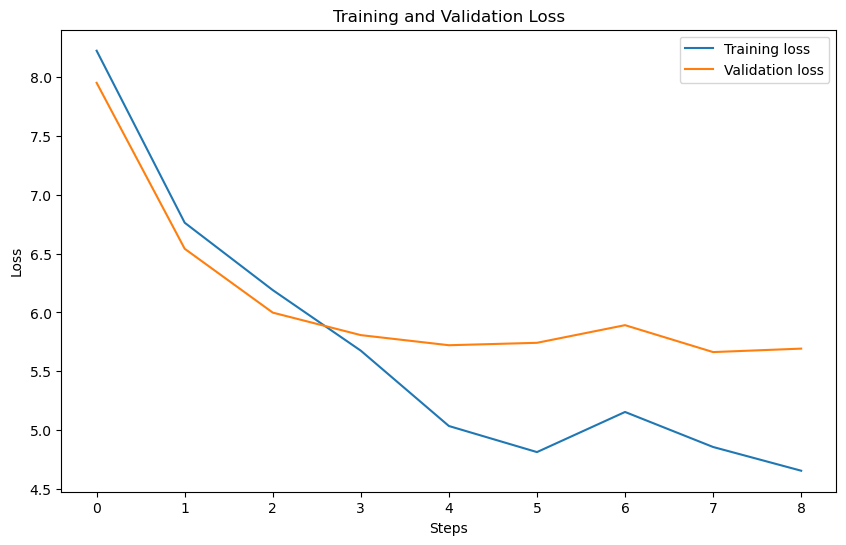

In [16]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

In [17]:
"""
    * This is an enhanced text generation function that incorporates temperature scaling and top-k sampling 
      - to control the randomness and quality of the generated text. 
    * generate function: generates new text one token at a time, but with two advanced techniques to avoid repetitive and boring outputs
        - Temperature Scaling: Controls the "creativity" vs. "safety" of the model's choices.
        - Top-K Sampling: Restricts the model's choices to only the K most likely next tokens.
            - For preventing it from choosing nonsensical words.
"""

def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):

    """
        * Loop for Token Generation.
        * The loop runs for max_new_tokens iterations, generating one token per step.
    """
    for _ in range(max_new_tokens):
        """
            * idx_cond crops the current sequence to the model's maximum context_size.
            * This is necessary because the model can't process infinitely long sequences.
        """
        idx_cond = idx[:, -context_size:]

        """
            * Get Model Predictions:
             - with torch.no_grad(): Disables gradient calculation for a massive speed boost during inference.
             - model(idx_cond): Gets the raw output (logits) for the entire sequence.
             - logits = logits[:, -1, :]: We only care about the logits for the very last token position, 
               as this is what we use to predict the next token.
        """
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        
        """
            * Apply Top-K Filtering (if enabled): This block ensures the model only chooses from the top_k most likely tokens.
             - torch.topk(logits, top_k): Finds the k largest logit values and their positions.
             - min_val: This is the value of the smallest logit in the top-k group.
             - torch.where(...): This replaces all logits that are less than the min_val with -inf.
               After softmax, these will have a probability of zero, effectively removing them from consideration.
        """
        if top_k is not None:                #2
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        """
            * Apply Temperature Scaling and Sample:
            * if temperature > 0.0: (Probabilistic Sampling)
             - logits = logits / temperature: Adjusts the logits. 
               - Higher temperatures (>1) make the distribution flatter (more random). 
               - Lower temperatures (<1) make it sharper (more deterministic).
             - torch.softmax(...): Converts the temperature-scaled logits into a probability distribution.
             - torch.multinomial(...): Samples from this distribution.
               - The model chooses a token randomly, but weighted by its probability. This is what introduces variety.

            * else: (Greedy Decoding - the old method)
             - torch.argmax(...): If temperature is 0, it falls back to the simple method.
               - Always taking the token with the highest probability.
               - This is deterministic and often repetitive.
        """
        if temperature > 0.0:          
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:    #4
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        """
            * Check for End-of-Sequence Token:
             - Provides an early stopping mechanism. 
              - If the model generates a special "end-of-sequence" token (like <|endoftext|>), 
                the generation loop stops early, even if max_new_tokens hasn't been reached.
              - This is useful for preventing the model from rambling.
        """
        if idx_next == eos_id:           
            break

        """
            * Append the New Token and Continue:
             - The newly generated token (idx_next) is appended to the existing sequence (idx).
             - This new, longer sequence becomes the input for the next iteration of the loop.
             - Finally, the fully generated sequence is returned.
        """
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [18]:
# Let’s now see this new generate function in action:

torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids('I would like to', tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)
print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 I would like to get. I’t, we because I’t know my


In [20]:
"""
    * This code saves the complete state of the training process to a file.
    * It captures not just the model's learned weights, but also the optimizer's state, 
      allowing you to pause and resume training exactly where you left off, without any loss of progress.

    * torch.save(): The PyTorch function that saves data to a file.
    * 'model_and_optimizer.pth': The filename for the checkpoint.
       The .pth extension is a conventional suffix for PyTorch model files.

    * model.state_dict(): This method returns a dictionary that contains a full snapshot of the model's learnable parameters 
      (all the weights and biases of every layer: embeddings, attention weights, feed-forward network weights, etc.).

    * optimizer.state_dict(): This method returns a dictionary that contains the internal state of the optimizer.
    * The "how" to continue learning. For an optimizer like AdamW, this includes crucial information like:
      - Momentum: The direction and velocity of the recent parameter updates.
      - Second Moments: Adaptive learning rate information for each parameter.
"""

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, 
    'model_and_optimizer.pth'
)

In [21]:
"""
   * Then we can restore the model and optimizer states by first loading the saved data via torch.
   * load and then using the load_state_dict method:

    - torch.load(): The PyTorch function that loads data from a file.
    - 'model_and_optimizer.pth': The filename of the checkpoint to load.
    - map_location=device: This is a critical safety feature. 
      It ensures the tensors in the checkpoint are loaded onto the correct device (e.g., CPU or GPU).

    * model = GPTModel(GPT_CONFIG_124M)
     - You must first create a new model instance with the exact same architecture as the one that was saved.
     - Why: The state_dict only contains the weights and parameters; it does not contain the code for the model's structure.

    * model.load_state_dict(checkpoint['model_state_dict']):
     - This accesses the part of the saved dictionary that contains all the model's weights.
     - This method copies those saved weights into the new model's layers. 
     - After this, the model is no longer "random"; it has the knowledge it had when the checkpoint was saved.

    * optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
     - Purpose: This is the key step for resuming training correctly. It restores the optimizer's internal state.
     - What it restores: For AdamW, this includes momentum buffers and per-parameter learning rate adjustments.
     - Without this, the optimizer would be "reset," and continuing training would be much less stable and efficient, 
       as it would lose its "memory" of how it was previously updating the weights.

    * model.train();
     - Prepares the model to continue training.
     - Reactivates training-specific behaviors like Dropout and Batch Normalization in training mode.
"""

checkpoint = torch.load('model_and_optimizer.pth', map_location=device) 
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train();